https://www.infiniteloop.co.jp/blog/2018/02/learning-keras-07/  
2018年02月20日 (火) 著者 ： nobuh  

# ノイズ入りsin波

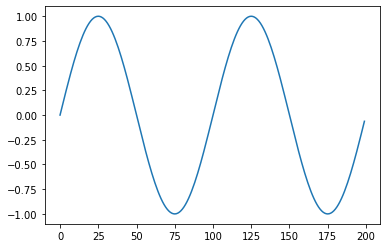

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sin2p(x,t=100):
    return np.sin(2.0*np.pi*x/t) # sin(2πx/t), t=周期

def sindata(t=100,cycle=2):
    x=np.arange(0,cycle*t) # 0からcycle*t未満の数
    return sin2p(x)
    
plt.plot(sindata(100,2)) # 1周期100個のデータ、2周期分
plt.show()

ノイズを加えます。

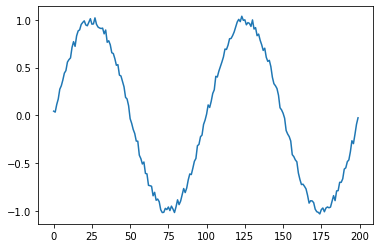

In [3]:
def noisy(Y,noise_range=(-0.05,0.05)):
    noise=np.random.uniform(noise_range[0],noise_range[1],size=Y.shape)
    
    return Y+noise

plt.plot(noisy(sindata(100,2),(-0.05,0.05)))
plt.show()

# 訓練と評価用にデータを加工

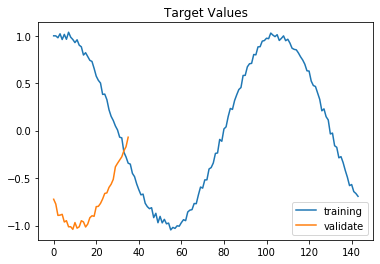

In [4]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

rawdata=noisy(sindata(100,2),(-0.05,0.05)) # 2周期分のノイズありsin波データを生成
inputlen=20 # 1入力データはデータ20個としました

input=[]
target=[]

for i in range(0,len(rawdata)-inputlen): # range(0,180), 0..179の180回実行
    input.append(rawdata[i:i+inputlen]) # [i:i+20]のスライスでiからi+19の20個を入力データに追加
    target.append(rawdata[i+inputlen]) # [i+20]がその直前までのデータ群[i:i+20]の正解値となるのでターゲットに追加
    
# numpyの3次元配列に変換
X=np.array(input).reshape(len(input),inputlen,1) # 入力データ(180,20,1)
Y=np.array(target).reshape(len(input),1) # ターゲット (180,1)

# トレーニングと評価用にデータを8:2に分割します。デフォルトがシャッフルなのでしないように
x,val_x,y,val_y=train_test_split(X,Y,test_size=int(len(X)*0.2),shuffle=False)

# 訓練データの正解値yと評価用データの正解値val_yのグラフ
plt.plot(y,label="training")
plt.plot(val_y,label="validate")
plt.title("Target Values")
plt.legend()
plt.show()

# SimpleRNNで学習させる

In [5]:
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Activation

n_in=1
n_hidden=20
n_out=1
epochs=10
batch_size=10

model=Sequential()
model.add(SimpleRNN(n_hidden,input_shape=(inputlen,n_in),kernel_initializer="random_normal"))
model.add(Dense(n_out,kernel_initializer="random_normal"))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error",optimizer=Adam(lr=0.01,beta_1=0.9,beta_2=0.999))
model.fit(x,y,batch_size=batch_size,epochs=epochs,validation_data=(val_x,val_y))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 144 samples, validate on 36 samples
Epoch 1/10
144/144 [==============================] - 2s 12ms/step - loss: 0.3581 - val_loss: 0.0563
Epoch 2/10
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0055
Epoch 3/10
144/144 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0048
Epoch 4/10
144/144 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 5/10
144/144 [==============================] - 0s 957us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/10
144/144 [==============================] - 0s 996us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/10
144/144 [==============================] - 0s 994us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/10
144/144 [==============================] - 0s 994us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/10
144/144 [======

# 学習済みモデルを使って予測する

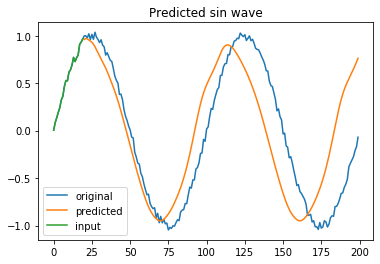

In [6]:
# 本来は評価データを使うべきですが、グラフの見栄え的に元データの左端を与えて
# 右側を予測させたかったので訓練データxの先頭を与えました

in_=x[:1] # xの先頭 (1,20,1)配列

# グラフで予測データ（オレンジ）が入力データ（緑）の後に来るように
# 予測データの先頭にNoneを20個入れてあります

predicted=[None for _ in range(inputlen)]

for _ in range(len(rawdata)-inputlen):
    out_=model.predict(in_) # 予測した値out_は(1,1)配列
    
    # in_を(20,1)配列に変換し、先頭1個をスライスして削り、末尾にout_を足す
    # 最後に再度(1,20,1)配列に変換して、全体を次のin_にする
    in_=np.concatenate((in_.reshape(inputlen,n_in)[1:],out_),axis=0).reshape(1,inputlen,n_in)
    
    # out_は(1,1)配列なので任意の長さの一次元配列に変換するreshape(-1)をかけてから予測データに追加
    predicted.append(out_.reshape(-1))

plt.title("Predicted sin wave")
plt.plot(rawdata,label="original")
plt.plot(predicted,label="predicted")
plt.plot(x[0],label="input")
plt.legend()
plt.show()